# Point-Source Photometry

If it's one thing an observational astronomer can do, it's measuring the flux of something. The easiest of these somethings are stars. We will see why that is.

When we talk about **flux** in the context of this notebook, what we mean is the number of photons recorded in an image like this:

![](https://apod.nasa.gov/apod/image/0202/ngc6397_hst.jpg)

Fluxes are often converted to magnitudes, a logarithmic measure. This goes back to the practice of ancient Arabs, who classified the brightest stars with number 1, and the faintest one they could see with number 6. The most common convention today is the so-called AB magnitude:

$$
m_\text{AB} = -2.5 \log_{10} f - 48.60
$$

where $f$ is the *spectral* flux in units of $erg/s/cm^2/Hz$, so it's the energy received by the instrument per time, collecting area and frequency.

This all boils down to counting photons.

## Exercise 1:

FITS is the ubiquitous file format in astronomy. Open the file `data/point-source.fits` with [astropy](https://docs.astropy.org/en/stable/io/fits/). Plot the image.

In [98]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import astropy.io.fits as fits
from astropy.modeling.functional_models import Gaussian2D
import astropy

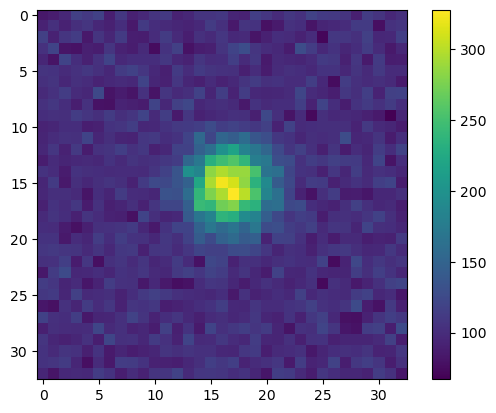

In [99]:
hdul = fits.open('data/point-source.fits')
image_data = hdul[0].data

plt.imshow(image_data, cmap='viridis') 
plt.colorbar()
plt.show()

hdul.close()

We can see a star with an apparently Gaussian shape, plus a fair bit of noise. 

Btw, what determines the shape of a star?

## Exercise 2:

Use astropy's `Gaussian2D.evaluate` [(docs)](https://docs.astropy.org/en/stable/api/astropy.modeling.functional_models.Gaussian2D.html) to create in image of a circular Gaussian model that looks similar to the data above. How many effective parameters does this model have?

Also, `numpy.meshgrid` is quite useful!

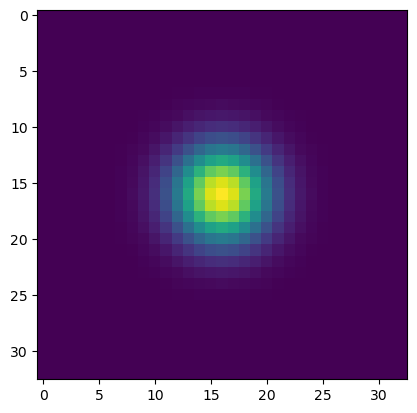

In [100]:
Nx = len(image_data)
X, Y = np.meshgrid(np.arange(Nx), np.arange(Nx))

model2 = Gaussian2D.evaluate(X, Y, 1, 16, 16, 3, 3, 0)
plt.imshow(model2)

## Exercise 3:

Assume that your guess for the position of the stars is correct, or that somebody told you the exact position (if the star is bright enough, Gaia can tell you very precisely its position on the sky). 
Finding the flux of the star is then a linear problem:

$$
I = f \cdot \mathrm{Gaussian} + s \cdot\mathrm{const} + \mathrm{noise}
$$

Flatten the image and write down the design matrix, including a constant term. 

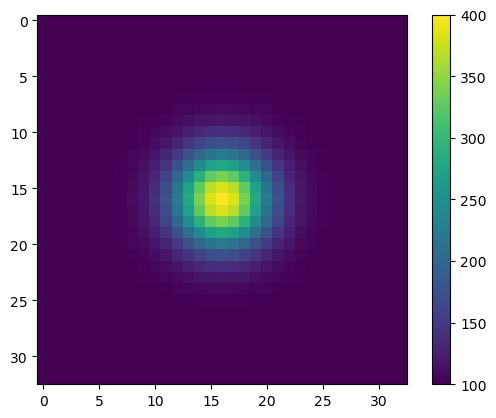

In [101]:
img_flat = image_data.flatten()
model_flat = model2.flatten()

const = np.ones(model_flat.shape)
X = np.stack((model_flat, const), axis=1)
theta = np.array((300, 100))
scaled_model_flat = X @ theta

plt.imshow(scaled_model_flat.reshape(33, 33))
plt.colorbar()


Like all counting experiments, the noise in this image follows a **Poisson distribution**. The nice thing about the Poisson distribution is that it quickly looks like the Gaussian when the counts are high enough. In this case, the noise is very well approximated by

$$
\sigma_i^2 = I_i
$$

where $i$ is the pixel index, and $I_i$ the intensity value of the pixel. Construct the covariance matrix $\Sigma$ for the flattened image, and determine the parameters $f$ and $s$ by solving the ordinary least-squares problem. Don't forget the covariance matrix! What's the meaning of the constant term?

In [102]:
Sigma_1 = np.diag(1 / image_data.flatten())

f, s = np.linalg.inv(X.T @ Sigma_1 @ X) @ X.T @ Sigma_1 @ img_flat

## Exercise 4:

Assume now that you don't know the position, or at least not well enough. Use `scipy.optimimze.minimize` to fit 5 parameters: $f$ and $s$ (as above) as well as the position $x_m$, $y_m$, and the width (i.e. standard deviation) of the Gaussian.

The function you want to minimize to find the "best-fit" parameters is the one that maximizes the likelihood. Since we're dealing with (assumed) Gaussian errors, this is the usual quadratic error form

$$
\chi^2(f, s, x_m, y_m, w;\ \lbrace I_i \rbrace) = \sum_i^N \frac{\left(I_i - \mathrm{Gaussian}(x_i, y_i; f, x_m, y_m, w) - s\right)^2}{\sigma_i^2},
$$

where $x_i$ and $y_i$ are the position of pixel $i$.

> Minimizing $\chi^2$ means altering the *parameters* at fixed data!

Note that `minimize` assumes that the function takes the entire parameter vector as **the first argument**!

So, a good function signature for this task is:

```python
def chi2(params, img):
    f, s, xm, ym, w = params
    ...

x0 = (160, 100, 16, 16, 3)
result = so.minimize(chi2, x0, args=(img, ))
```

This uses a convenient separation of optimization parameters from other arguments `chi2` needs for its computation. It also frees you to define the parameter vector `params` any way you want as long as its consistent everywhere.

Also, for `x0`, start with your best-guess for the positions as well as the results from Exercise 3.

In [103]:
import scipy.optimize as cp

In [104]:
def chi2(params, img, X, Y):
    f, s, xm, ym, w = params

    theta = 0
    model = Gaussian2D.evaluate(X, Y, f, xm, ym, w, w, theta) + s
    return np.sum((img - model)**2 / img)

x0 = (168.521, 98.409, 16., 16., 3.)
result = cp.minimize(chi2, x0, args=(image_data, Nx, Nx))

How would you determine if the fit is actually good? There are multiple ways, but often the most intuitive is to look at the residuals, i.e. the difference between data and model.

Make a plot of your best-fit residuals.

In [105]:
X, Y = np.meshgrid(np.arange(Nx), np.arange(Nx))

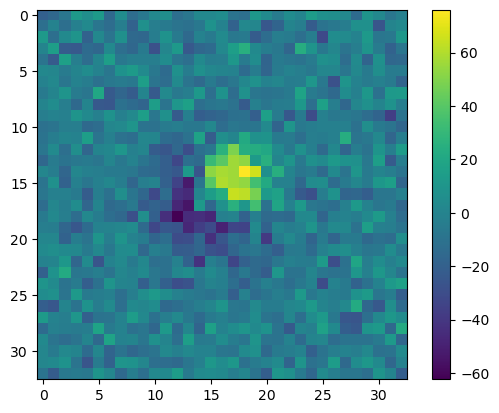

In [106]:
f, s, xm, ym, w = result.x
theta = 0
model = Gaussian2D.evaluate(X, Y, f, xm, ym, w, w, theta) + s

residual = image_data - model
plt.imshow(residual)
plt.colorbar()

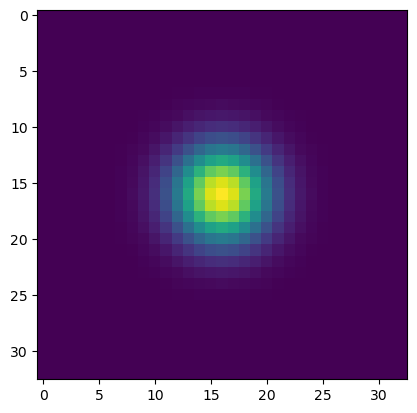

In [107]:
plt.imshow(model)

It *should* look like your error model, which in our cause is a non-uniform Gaussian with higher variances in regions with higher pixel intensity.